📊 Loading conversation pairs...
✅ Loaded 4455 conversation pairs
Columns: ['customer_text', 'customer_processed', 'response_text', 'response_processed', 'company', 'conversation_id']

Sample conversation:
Customer: @sprintcare I have sent several private messages and no one is responding as usual...
Response: @115712 I understand. I would like to assist you. We would need to get you into a private secured li...

🤖 Testing Template-Based Generator:

👤 Customer: Hi, I need help with my account
🏷️ Intent: greeting
🤖 Response: Hello! Thank you for contacting us. How can I assist you today?

👤 Customer: My order hasn't arrived yet
🏷️ Intent: order_issue
🤖 Response: I'll be happy to check on your order status. Could you please provide your order number?

👤 Customer: This is the worst service ever!
🏷️ Intent: greeting
🤖 Response: Hello! Thank you for contacting us. How can I assist you today?

👤 Customer: The app is not working properly
🏷️ Intent: technical
🤖 Response: I'll help you fix this 

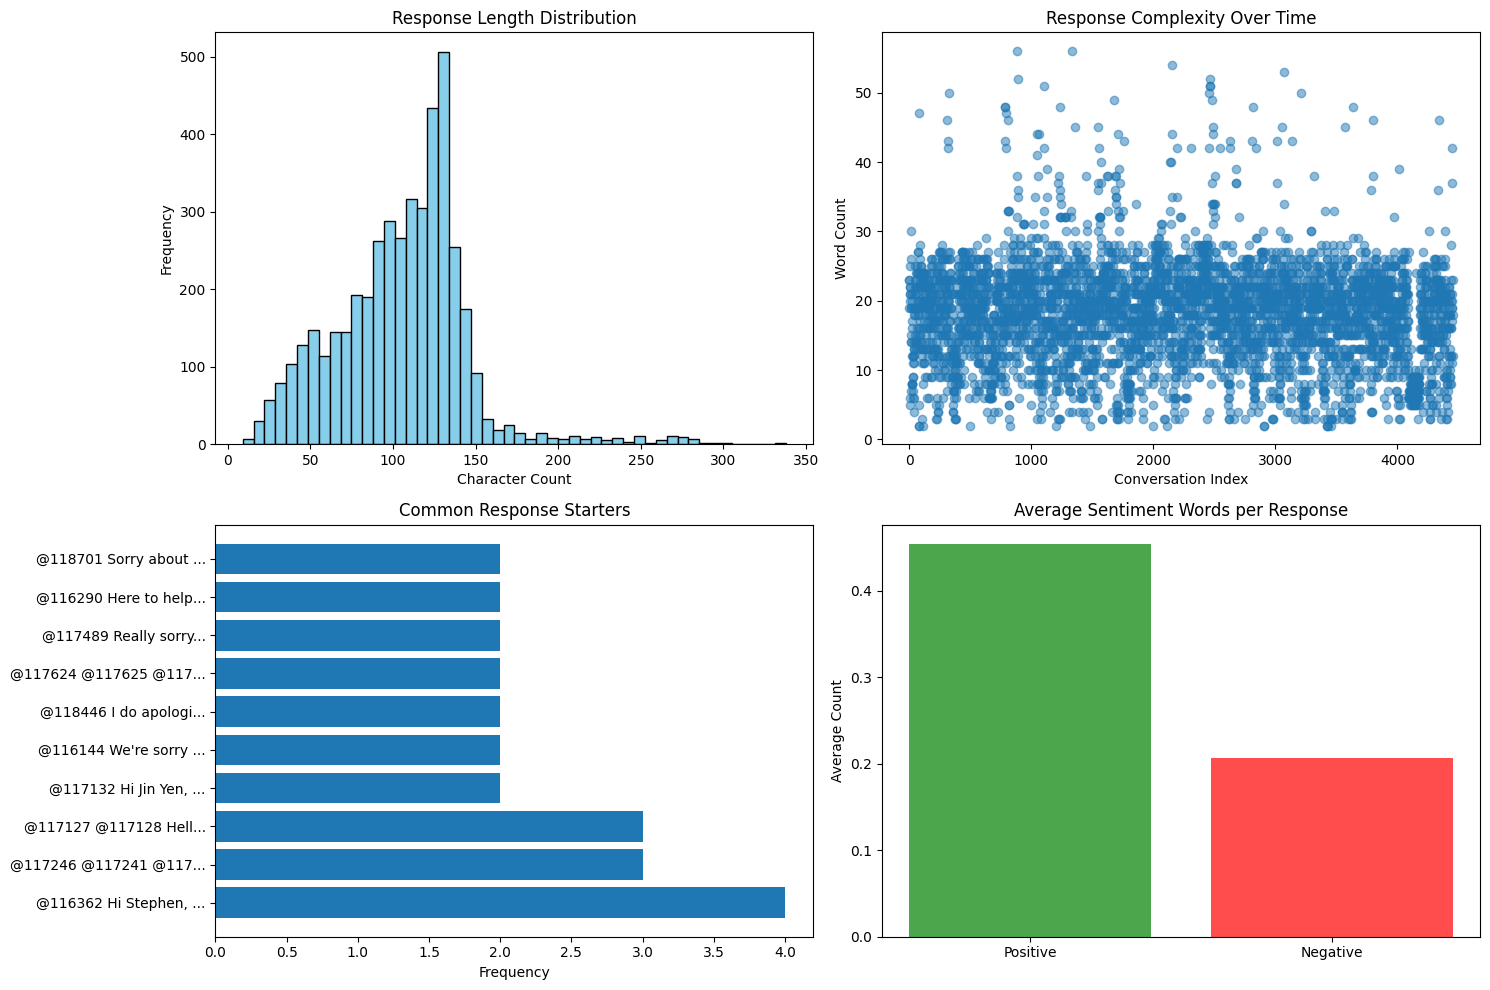


✅ Response Generator Setup Complete!

Available generators:
1. template_gen - Template-based responses
2. retrieval_gen - Retrieval-based responses
3. hybrid_gen - Hybrid approach (recommended)

Usage: response = hybrid_gen.generate_response('customer query')


In [ ]:
#!/usr/bin/env python3
"""
Response Generation for Customer Support
"""

import numpy as np
import pandas as pd
import re
from collections import defaultdict
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For advanced models (optional)
try:
    from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration
    import torch
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print(" Transformers not available. Using template-based methods only.")

#   1: Load conversation pairs
print(" Loading conversation pairs...")
conv_pairs = pd.read_csv('processed_data/conversation_pairs.csv')
print(f" Loaded {len(conv_pairs)} conversation pairs")
print(f"Columns: {conv_pairs.columns.tolist()}")
print("\nSample conversation:")
if len(conv_pairs) > 0:
    sample = conv_pairs.iloc[0]
    print(f"Customer: {sample['customer_text'][:100]}...")
    print(f"Response: {sample['response_text'][:100]}...")

#   2: Template-Based Response Generator
class TemplateBasedGenerator:
    """Simple but effective template-based response generation"""
    
    def __init__(self):
        self.templates = {
            'greeting': {
                'patterns': ['hi', 'hello', 'hey', 'good morning', 'good afternoon'],
                'responses': [
                    "Hello! Thank you for contacting us. How can I assist you today?",
                    "Hi there! I'm here to help. What can I do for you?",
                    "Welcome! How may I help you today?",
                    "Hello! I'd be happy to help you. What seems to be the issue?"
                ]
            },
            'order_issue': {
                'patterns': ['order', 'delivery', 'package', 'shipment', 'tracking'],
                'responses': [
                    "I understand you have a concern about your order. Let me look into that for you right away.",
                    "I'll be happy to check on your order status. Could you please provide your order number?",
                    "I apologize for any inconvenience with your order. Let me investigate this immediately.",
                    "I can definitely help you track your order. I'll need your order details to assist you better."
                ]
            },
            'complaint': {
                'patterns': ['angry', 'frustrated', 'disappointed', 'terrible', 'worst', 'bad'],
                'responses': [
                    "I sincerely apologize for the inconvenience you've experienced. Let me help resolve this for you.",
                    "I'm truly sorry to hear about your experience. I'll do everything I can to make this right.",
                    "I understand your frustration and I apologize. Let's work together to solve this issue.",
                    "I'm very sorry you've had this experience. Your satisfaction is important to us, and I'll help resolve this."
                ]
            },
            'technical': {
                'patterns': ['not working', 'broken', 'error', 'problem', 'issue', 'bug'],
                'responses': [
                    "I'm sorry you're experiencing technical difficulties. Let me help troubleshoot this issue.",
                    "I understand you're having technical problems. Can you describe what's happening in more detail?",
                    "Let me help you resolve this technical issue. Have you tried restarting the application?",
                    "I'll help you fix this problem. First, can you tell me when this issue started?"
                ]
            },
            'refund': {
                'patterns': ['refund', 'money back', 'return', 'cancel'],
                'responses': [
                    "I understand you'd like to discuss a refund. Let me review your account and available options.",
                    "I can help you with the refund process. May I have your order number to get started?",
                    "I'll be happy to assist with your refund request. Let me check our return policy for you.",
                    "Of course, I can help process your refund. I'll need to verify some information first."
                ]
            },
            'thanks': {
                'patterns': ['thank', 'thanks', 'appreciate', 'helpful'],
                'responses': [
                    "You're very welcome! Is there anything else I can help you with?",
                    "Happy to help! Please don't hesitate to reach out if you need anything else.",
                    "It was my pleasure assisting you today. Have a great day!",
                    "You're welcome! We're always here if you need further assistance."
                ]
            },
            'default': {
                'patterns': [],
                'responses': [
                    "I understand your concern. Let me look into this for you.",
                    "Thank you for reaching out. I'll do my best to assist you with this.",
                    "I'm here to help. Could you provide more details about your issue?",
                    "I'd be happy to help you. Let me gather some information to better assist you."
                ]
            }
        }
    
    def classify_intent(self, text):
        """Classify customer intent based on keywords"""
        text_lower = text.lower()
        
        for intent, data in self.templates.items():
            if intent == 'default':
                continue
            for pattern in data['patterns']:
                if pattern in text_lower:
                    return intent
        
        return 'default'
    
    def generate_response(self, customer_text):
        """Generate appropriate response based on intent"""
        intent = self.classify_intent(customer_text)
        responses = self.templates[intent]['responses']
        return random.choice(responses), intent

# Test template generator
print("\n Testing Template-Based Generator:")
template_gen = TemplateBasedGenerator()

test_queries = [
    "Hi, I need help with my account",
    "My order hasn't arrived yet",
    "This is the worst service ever!",
    "The app is not working properly",
    "I want a refund immediately",
    "Thanks for your help!"
]

for query in test_queries:
    response, intent = template_gen.generate_response(query)
    print(f"\n Customer: {query}")
    print(f" Intent: {intent}")
    print(f" Response: {response}")

#   3: Retrieval-Based Response Generator
class RetrievalBasedGenerator:
    """Find most similar historical response"""
    
    def __init__(self, conversation_pairs):
        self.pairs = conversation_pairs.dropna()
        self.vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        
        # Fit vectorizer on customer texts
        self.customer_vectors = self.vectorizer.fit_transform(self.pairs['customer_processed'])
        
    def find_similar_queries(self, query, top_k=5):
        """Find most similar historical customer queries"""
        # Vectorize query
        query_vector = self.vectorizer.transform([query])
        
        # Calculate similarities
        similarities = cosine_similarity(query_vector, self.customer_vectors).flatten()
        
        # Get top k similar indices
        top_indices = similarities.argsort()[-top_k:][::-1]
        
        results = []
        for idx in top_indices:
            results.append({
                'customer_text': self.pairs.iloc[idx]['customer_text'],
                'response_text': self.pairs.iloc[idx]['response_text'],
                'similarity': similarities[idx]
            })
        
        return results
    
    def generate_response(self, query, strategy='best'):
        """Generate response based on retrieval strategy"""
        similar = self.find_similar_queries(query)
        
        if not similar:
            return "I'll help you with that. Could you provide more details?"
        
        if strategy == 'best':
            # Return response from most similar query
            return similar[0]['response_text']
        elif strategy == 'weighted':
            # Weighted random selection based on similarity
            weights = [s['similarity'] for s in similar]
            total = sum(weights)
            if total > 0:
                weights = [w/total for w in weights]
                chosen = np.random.choice(similar, p=weights)
                return chosen['response_text']
        
        return similar[0]['response_text']

# Initialize retrieval generator
if len(conv_pairs) > 0:
    print("\n Initializing Retrieval-Based Generator...")
    retrieval_gen = RetrievalBasedGenerator(conv_pairs)
    
    # Test retrieval generator
    print("\n Testing Retrieval-Based Generator:")
    test_queries = [
        "My order is late",
        "How do I reset my password?",
        "I'm having trouble with the app"
    ]
    
    for query in test_queries:
        print(f"\n Customer: {query}")
        similar = retrieval_gen.find_similar_queries(query, top_k=3)
        
        if similar:
            print(f"\n Most similar historical query (similarity: {similar[0]['similarity']:.3f}):")
            print(f"   Historical: {similar[0]['customer_text'][:100]}...")
            print(f"   Response: {similar[0]['response_text'][:100]}...")
            
            response = retrieval_gen.generate_response(query)
            print(f"\n Generated Response: {response[:150]}...")

#   4: Hybrid Response Generator
class HybridResponseGenerator:
    """Combines template and retrieval approaches"""
    
    def __init__(self, conversation_pairs):
        self.template_gen = TemplateBasedGenerator()
        self.retrieval_gen = RetrievalBasedGenerator(conversation_pairs) if len(conversation_pairs) > 0 else None
        
    def generate_response(self, query, confidence_threshold=0.7):
        """Generate response using hybrid approach"""
        responses = []
        
        # Get template response
        template_response, intent = self.template_gen.generate_response(query)
        responses.append({
            'source': 'template',
            'response': template_response,
            'confidence': 0.6,  # Base confidence for templates
            'intent': intent
        })
        
        # Get retrieval response if available
        if self.retrieval_gen:
            similar = self.retrieval_gen.find_similar_queries(query, top_k=1)
            if similar and similar[0]['similarity'] > 0.5:
                responses.append({
                    'source': 'retrieval',
                    'response': similar[0]['response_text'],
                    'confidence': similar[0]['similarity'],
                    'intent': None
                })
        
        # Choose best response
        best_response = max(responses, key=lambda x: x['confidence'])
        
        return best_response

# Test hybrid generator
print("\n Testing Hybrid Generator:")
hybrid_gen = HybridResponseGenerator(conv_pairs)

test_scenarios = [
    "Hello, I need help",
    "My package hasn't arrived and it's been 2 weeks!",
    "The website keeps crashing when I try to checkout",
    "Thanks for resolving my issue"
]

for scenario in test_scenarios:
    result = hybrid_gen.generate_response(scenario)
    print(f"\n Customer: {scenario}")
    print(f" Response: {result['response']}")
    print(f" Source: {result['source']} (confidence: {result['confidence']:.2f})")
    if result['intent']:
        print(f" Intent: {result['intent']}")

#   5: Response Quality Metrics
def evaluate_responses(test_pairs, generator):
    """Evaluate response generation quality"""
    results = []
    
    for _, pair in test_pairs.iterrows():
        customer_text = pair['customer_text']
        actual_response = pair['response_text']
        
        # Generate response
        if hasattr(generator, 'generate_response'):
            if isinstance(generator, HybridResponseGenerator):
                result = generator.generate_response(customer_text)
                generated_response = result['response']
            else:
                generated_response = generator.generate_response(customer_text)
                if isinstance(generated_response, tuple):
                    generated_response = generated_response[0]
        else:
            generated_response = "No response generated"
        
        # Simple similarity metric (you can add more sophisticated metrics)
        vectorizer = TfidfVectorizer().fit([actual_response, generated_response])
        vectors = vectorizer.transform([actual_response, generated_response])
        similarity = cosine_similarity(vectors[0], vectors[1])[0][0]
        
        results.append({
            'customer': customer_text[:50] + '...',
            'actual': actual_response[:50] + '...',
            'generated': generated_response[:50] + '...',
            'similarity': similarity
        })
    
    return pd.DataFrame(results)

# Evaluate if we have enough data
if len(conv_pairs) > 10:
    print("\n Evaluating Response Generators:")
    
    # Create test set
    test_pairs = conv_pairs.sample(min(10, len(conv_pairs)))
    
    # Evaluate template generator
    template_results = evaluate_responses(test_pairs, template_gen)
    print(f"\nTemplate Generator - Avg Similarity: {template_results['similarity'].mean():.3f}")
    
    # Evaluate hybrid generator
    hybrid_results = evaluate_responses(test_pairs, hybrid_gen)
    print(f"Hybrid Generator - Avg Similarity: {hybrid_results['similarity'].mean():.3f}")

#   6: Advanced Response Generator (if transformers available)
if TRANSFORMERS_AVAILABLE:
    class NeuralResponseGenerator:
        """Simple wrapper for transformer-based generation"""
        
        def __init__(self, model_name="microsoft/DialoGPT-small"):
            print(f"Loading {model_name}...")
            self.generator = pipeline("text-generation", model=model_name)
            
        def generate_response(self, query, max_length=100):
            # Format for dialogue
            prompt = f"Customer: {query}\nAgent:"
            
            # Generate
            result = self.generator(
                prompt, 
                max_length=max_length,
                num_return_sequences=1,
                temperature=0.7,
                pad_token_id=50256
            )
            
            # Extract response
            full_text = result[0]['generated_text']
            response = full_text.split("Agent:")[-1].strip()
            
            # Clean up
            response = response.split("Customer:")[0].strip()
            
            return response
    
    print("\n Neural Response Generator Available!")
    print("To use: neural_gen = NeuralResponseGenerator()")
    print("Then: response = neural_gen.generate_response('your query')")

#   7: Save generators for later use
import pickle

print("\n Saving response generators...")

# Save template generator
with open('template_generator.pkl', 'wb') as f:
    pickle.dump(template_gen, f)
print(" Template generator saved")

# Save hybrid generator
with open('hybrid_generator.pkl', 'wb') as f:
    pickle.dump(hybrid_gen, f)
print(" Hybrid generator saved")

#   8: Interactive Demo
def interactive_demo(generator):
    """Interactive demo for testing responses"""
    print("\n Interactive Response Generation Demo")
    print("Type 'quit' to exit\n")
    
    while True:
        query = input(" Customer: ")
        if query.lower() in ['quit', 'exit', 'q']:
            break
            
        if isinstance(generator, HybridResponseGenerator):
            result = generator.generate_response(query)
            print(f" Agent: {result['response']}")
            print(f"   (Source: {result['source']}, Confidence: {result['confidence']:.2f})")
        else:
            response = generator.generate_response(query)
            if isinstance(response, tuple):
                response = response[0]
            print(f" Agent: {response}")
        print()

# Uncomment to run interactive demo
# interactive_demo(hybrid_gen)

#   9: Response Analysis Dashboard
def create_response_dashboard(conv_pairs):
    """Create visualization dashboard for response patterns"""
    
    # Response length distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Response length distribution
    response_lengths = conv_pairs['response_text'].str.len()
    axes[0, 0].hist(response_lengths, bins=50, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Response Length Distribution')
    axes[0, 0].set_xlabel('Character Count')
    axes[0, 0].set_ylabel('Frequency')
    
    # 2. Response time patterns (simulated - in real scenario, you'd have timestamps)
    response_words = conv_pairs['response_text'].str.split().str.len()
    axes[0, 1].scatter(conv_pairs.index, response_words, alpha=0.5)
    axes[0, 1].set_title('Response Complexity Over Time')
    axes[0, 1].set_xlabel('Conversation Index')
    axes[0, 1].set_ylabel('Word Count')
    
    # 3. Common response starters
    starters = conv_pairs['response_text'].str[:20].value_counts().head(10)
    axes[1, 0].barh(range(len(starters)), starters.values)
    axes[1, 0].set_yticks(range(len(starters)))
    axes[1, 0].set_yticklabels([s[:20] + '...' for s in starters.index])
    axes[1, 0].set_title('Common Response Starters')
    axes[1, 0].set_xlabel('Frequency')
    
    # 4. Response sentiment (simple positive/negative word count)
    positive_words = ['thank', 'please', 'happy', 'glad', 'appreciate']
    negative_words = ['sorry', 'apologize', 'unfortunately', 'problem', 'issue']
    
    pos_count = conv_pairs['response_text'].str.lower().apply(
        lambda x: sum(word in x for word in positive_words)
    ).mean()
    neg_count = conv_pairs['response_text'].str.lower().apply(
        lambda x: sum(word in x for word in negative_words)
    ).mean()
    
    axes[1, 1].bar(['Positive', 'Negative'], [pos_count, neg_count], 
                   color=['green', 'red'], alpha=0.7)
    axes[1, 1].set_title('Average Sentiment Words per Response')
    axes[1, 1].set_ylabel('Average Count')
    
    plt.tight_layout()
    plt.show()

# Create dashboard 
if len(conv_pairs) > 0:
    print("\n Response Pattern Analysis:")
    create_response_dashboard(conv_pairs)

print("\n Response Generator Setup Complete!")
print("\nAvailable generators:")
print("1. template_gen - Template-based responses")
print("2. retrieval_gen - Retrieval-based responses")
print("3. hybrid_gen - Hybrid approach (recommended)")
print("\nUsage: response = hybrid_gen.generate_response('customer query')")